In [1]:
# import libraries
%matplotlib inline
import numpy as np
#import csv
import matplotlib.pyplot as plt
import pandas as pd
import glob
import ulmo
import os
import scipy.spatial
import scipy.stats
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

In [2]:
# plotting utilities
def lin_trend_plot(start_x, y,title, xlabel, ylabel) : 
# plots x,y (need to be np array) and calculates and prints their best fit line
    ind = ~np.isnan(y.values)# & ~np.isnan(x) # subset values that aren't NaNs
    x = np.arange(0,y.shape[0])
    m, b, r_value, p, std_err = scipy.stats.linregress(x[ind],y[ind])
    plt.scatter(x+start_x,y)
    plt.plot(x+start_x, m*x+b, color = 'black')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    plt.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('r = %.2f'%(r_value), xy=(.5, .85), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('p = %.2f'%(p), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('N = %i'%(ind.shape), xy=(.5, .75), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m, b, r_value, p, std_err

def easy_scatter(x,y,title, xlabel, ylabel) : 
# plots x,y (need to be np array) and calculates and prints their best fit line
    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    m,b = np.polyfit(x[ind],y[ind],1)
    r, p = scipy.stats.pearsonr(x[ind], y[ind]) #np.corrcoef(x[ind],y[ind])[0,1]
    plt.scatter(x,y)
    plt.plot(x, m*x+b, color = 'black')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    plt.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('r = %.2f'%(r), xy=(.5, .85), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('p = %.2f'%(p), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('N = %i'%(ind.shape), xy=(.5, .75), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m, r, p

def how_UHI_varies(mean_UHIs, closeststations_distance): 
    plt.figure(figsize= [12,4])
    plt.subplot(1,3,1)
    data = mean_UHIs[~np.isnan(mean_UHIs)]
    plt.hist(data)
    plt.xlabel('$\Delta T$ ($\Delta ^\circ$C)')
    plt.ylabel('Count')
    plt.annotate('min = %.2f'%(data.min()), xy=(0, .94), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('max = %.2f'%(data.max()), xy=(0, .89), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('$\mu$ = %.2f'%(data.mean()), xy=(0, .84), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('$\sigma$ = %.2f'%(data.std()), xy=(0, .79), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.title('Histogram of $\Delta T$')

    plt.subplot(1,3,2)
    m,r,p = easy_scatter(closeststations_distance, mean_UHIs, 
                 'Distance to rural station vs. $\Delta T$ ', 
             'Distance to rural station (degrees lat/lon)', '$\Delta T$ ($\Delta ^\circ$C)',
             )

    plt.subplot(1,3,3)
    m2,r2,p2 = easy_scatter(ghcn.loc[rural_station_list].Brightness.values, mean_UHIs, 
                 'Brightness versus $\Delta T$', 
                 'Satellite Brightness Index', '$\Delta T$ ($\Delta ^\circ$C)',
                 )
    return m,r,p

In [3]:
# readin in GHCN data 
ghcn = pd.read_fwf('data/ghcnd-stations.txt', colspecs = [(0,11), (12,19), (21,29), (31,36),(38,40), (41,70), (72,74),(76,78),(80,85)], header = None) 
colnames = ['GHCN ID', 'lat', 'lon', 'elevation', 'state', 'name', 'gsn flag', 'HCN/CRN FLAG', 'WMO ID']
ghcn.columns = colnames

# append the brightness index 
BI = np.load('data/brightnessGHCN.npy')
ghcn['Brightness'] = BI

currentstations = ulmo.ncdc.ghcn_daily.get_stations(start_year=2005, end_year = 2016, elements = ['TMIN', 'TMAX', 'AWND'], as_dataframe=True, update=False)
currentGHCNstations = np.intersect1d(currentstations.id, ghcn.index.values) #ghcn['GHCN ID'].values)
#ghcnSubset = ghcn.set_index('GHCN ID').loc[currentstations.id.values]
ghcn = ghcn.set_index('GHCN ID').loc[currentstations.id.values]
ghcn = ghcn[ghcn.index.str.contains('US')]
# at this point, ghcn must have the station id set as the index 

In [4]:
# ghcn_noairport = ghcn[~ghcn.name.str.contains('INTL')]
# ghcn_noairport = ghcn_noairport[~ghcn_noairport.name.str.contains(' AP')]
# ghcn_noairport = ghcn_noairport[~ghcn_noairport.name.str.contains('AIRPORT')]
# ghcn = ghcn_noairport.set_index('GHCN ID').loc[currentstations.id.values]

In [5]:
# generate atlas of cities and k-d tree 
atlas = pd.read_csv('data/world_cities.csv')
atlas = atlas[(atlas['country'] == 'United States of America')]# & (atlas['pop']>100000)]
atlas = atlas.set_index('city')
tree = scipy.spatial.cKDTree(ghcn[['lon', 'lat']].values, leafsize=100)
#atlas = atlas[atlas['pop']> 500000]

In [6]:
# pairs = pd.read_csv('NovUSpairs_stationlengths_stationavailability75.csv')
# paired_df = pairs[(pairs['Urban brightness'] - pairs['Rural brightness'] > 30) & (pairs['Urban station'].str.contains('US'))]
# paired_df = paired_df.drop(2)
# drop_cities = ['Mesa','Long Beach','St. Petersburg', 'Grand Prairie', 'Virginia Beach', 'St. Paul' ]
# paired_df = paired_df.set_index(paired_df['City']).drop(drop_cities)
paired_df = pd.read_csv('USpairs2005-2015.csv').set_index('City', drop = False)

In [54]:
# pairs = pd.read_csv('USghcnpairs_stationlengths.csv')
# paired_df = pairs[(pairs['Urban brightness'] - pairs['Rural brightness'] > 30) & (pairs['Urban station'].str.contains('US'))]
# pairs = pd.read_csv('CleanedNovUSpairs_stationlengths.csv')
# paired_df = pairs[(pairs['Urban brightness'] - pairs['Rural brightness'] > 30) & (pairs['Urban station'].str.contains('US'))]

# results = np.ones([paired_df.shape[0],11])*np.nan # save out min,max, mean, std, m,r,p
# results_filepath = 'plots/version2/UHIvariance/'

In [7]:
results = np.ones([paired_df.shape[0],11])*np.nan # save out min,max, mean, std, m,r,p
results_filepath = 'plots/version5/UHIvariance/'

In [21]:
brightness_threshold = 25
#redo_cities = np.where(np.isnan(results[:,0]))[0]
#for i in range(0,paired_df.shape[0]): #
cities = [
#'Grand Prairie',
 'Irvine',
 'Fort Lauderdale',
 'Long Beach',
 'Virginia Beach',
 'San Bernardino',
 'St. Paul',
 'Ft. Worth',
 'Milwaukee',
 'Philadelphia',
 'Detroit',
 'San Francisco',
 'New York']
for city in cities : #paired_df.index : 
    ### Set variables
    #city = paired_df.iloc[i]['City']
    #city = unicode(city, errors = 'ignore')
    print city
    urbanID = paired_df.loc[city]['Urban station']
    #urbanID = paired_df.iloc[i]['Urban station']
    urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
                                         as_dataframe=True, update = False)
    # set lat/lon
    if city == 'Grand Prairie': 
        city = 'Arlington'
    try: # if  
        if atlas[atlas.index==city].shape[0]>1 : # if more than one hit for the city, eg, Kansas City (MO and KS)
                lat = atlas.loc[city]['lat'][0]
                lon = atlas.loc[city]['lng'] [1]
        else: 
            lat = atlas[atlas['pop']> 300000].loc[city]['lat']
            lon = atlas[atlas['pop']> 300000].loc[city]['lng'] 
        
        
#         closeststations = tree.query([lon,lat], k =15, distance_upper_bound=1.5) #used in pairing algorithm: .5
#         ind = ~np.isinf(closeststations[0])
#         urban_ind = np.where( ghcn.iloc[closeststations[1][ind]].index == urbanID)[0][0]
#         rural_station_list = np.setdiff1d(ghcn.iloc[closeststations[1][ind]].index, urbanID)
#         #rural_station_differences = closeststations[0][ind]
    # try to fix if there are two such cities in the atlas; take the second one
    except IndexError: 
        lat = atlas[atlas['pop']> 300000].loc[city]['lat'][1]
        lon = atlas[atlas['pop']> 300000].loc[city]['lng'][1]
#         closeststations = tree.query([lon,lat], k =15, distance_upper_bound=1.5) #used in pairing algorithm: .5
#         ind = ~np.isinf(closeststations[0])
#         urban_ind = np.where( ghcn.iloc[closeststations[1][ind]].index == urbanID)[0][0]
#         rural_station_list = np.setdiff1d(ghcn.iloc[closeststations[1][ind]].index, urbanID)
#         #rural_station_differences = closeststations[0][ind]
        
#     # only do this with dim stations
#     a = np.where((ghcn.loc[rural_station_list].Brightness < 25)==True)
#     dim_station_list = ghcn.loc[rural_station_list].iloc[a].index
#     rural_station_list = dim_station_list
#     rural_station_distances = 
    # find the closest stations
    closeststations = tree.query([lon,lat], k =35, distance_upper_bound=1.5) #used in pairing algorithm: .5
    cols = ['Distance', 'Index', 'GHCNID', 'Brightness']
    try: 
        # get station ids
        stations = pd.DataFrame(np.array([closeststations[0][~np.isinf(closeststations[0])].astype(float),
                                          closeststations[1][~np.isinf(closeststations[0])],
                                          ghcn.iloc[closeststations[1][~np.isinf(closeststations[0])]]['Brightness'].index,
                                          ghcn.iloc[closeststations[1][~np.isinf(closeststations[0])]]['Brightness'].values]).T, 
                    columns = cols).set_index('GHCNID').drop(urbanID)
        stations = stations[~np.isinf(stations['Distance'].values.astype(float))]
    except IndexError: 
        closeststations = closeststations[0]
        stations = pd.DataFrame(np.array([closeststations[0].astype(float),closeststations[1], ghcn.iloc[closeststations[1]]['Brightness'].index, ghcn.iloc[closeststations[1]]['Brightness'].values]).T, 
                columns = cols).set_index('GHCNID').drop(urbanID)
        stations = stations[~np.isinf(stations['Distance'].values.astype(float))]
    except ValueError: # got this when urban ID wasn't in the stations for Jacksonville, should maybe check
        stations = pd.DataFrame(np.array([closeststations[0].astype(float),closeststations[1], ghcn.iloc[closeststations[1]]['Brightness'].index, ghcn.iloc[closeststations[1]]['Brightness'].values]).T, 
            columns = cols).set_index('GHCNID')#.drop(urbanID)
        stations = stations[~np.isinf(stations['Distance'].values.astype(float))]

    #rural_stations = stations.index
    # select only dim stations
    rural_station_list = stations[stations.Brightness < 25].index
    rural_distance = stations[stations.Brightness < 25].Distance.values.astype(float)

    # if there are rural stations available, do analysis
    if len(rural_station_list) > 0 :# & (ind.sum() > 0): 
        # preallocate
        mean_UHIs = np.ones(len(rural_station_list))*np.nan
        mean_ms = np.ones(len(rural_station_list))*np.nan
        mean_rs = np.ones(len(rural_station_list))*np.nan
        mean_ps = np.ones(len(rural_station_list))*np.nan
        mean_UHIslopes =  np.ones(len(rural_station_list))*np.nan
        mean_Trslopes =  np.ones(len(rural_station_list))*np.nan

        ii = 0 
        # loop over rural stations
        for rural_id in rural_station_list: #[2:] : 
            # read in rural data
            ruraldata = ulmo.ncdc.ghcn_daily.get_data(rural_id, as_dataframe=True, update=False)
            try: 
            #if ('TMIN' in urbandata.keys()) & ('TMIN' in ruraldata.keys()) & (np.intersect1d(urbandata['TMIN']['2005-01-01':].index, ruraldata['TMIN']['2005-01-01':].index).shape[0] > 300): 

                # extract summertime min daily temps
                rural_tmin = pd.to_numeric(ruraldata['TMIN']['2005-01-01':].value/10.) #rural tmin
                urban_tmin = pd.to_numeric(urbandata['TMIN']['2005-01-01':].value/10.) 

                # extract summertime data 
                rural_summer = rural_tmin[(rural_tmin.index.month >= 6) & (rural_tmin.index.month <= 8)]
                urban_summer = urban_tmin[(urban_tmin.index.month >= 6) & (urban_tmin.index.month <= 8)]

                # clean data: eliminate min temperatures below 4 or above 35
                rural_summer = rural_summer[(rural_summer>4) & (rural_summer<35)]
                urban_summer = urban_summer[(urban_summer>4) & (urban_summer < 35)]

                #calculate UHI
                UHI = urban_summer - rural_summer
                mean_UHIs[ii] = np.nanmean(UHI)
                
                if rural_summer.shape[0] < UHI.shape[0] : # if rural data smaller, subset UHI
                    ind = ~np.isnan(rural_summer) & ~np.isnan(UHI[rural_summer.index])
                    if ind.sum() > 2: 
                        m, r, p = easy_scatter(rural_summer[ind],UHI[rural_summer.index][ind],
                                               '%s JJA $T_r$ vs. $\Delta T$'%city, 'Rural Temp ($^\circ$C)', 'UHI ($\Delta ^\circ$C)')
                else: # otherwise, subset rural data with UHI
                    ind = ~np.isnan(rural_summer[UHI.index]) & ~np.isnan(UHI)
                    if ind.sum() > 2: 
                        m, r, p = easy_scatter(rural_summer[UHI.index][ind],UHI[ind],
                                                   '%s JJA $T_r$ vs. $\Delta T$'%city, 'Rural Temp ($^\circ$C)', 'UHI ($\Delta ^\circ$C)')
                plt.close()
#                     # subset values that aren't NaNs
#             ind = ~np.isnan(rural_summer) & ~np.isnan(UHI)

# #                     # plot T_r versus UHI
#             if ind.sum() > 2: 
# #                         plt.figure()
#                 #### plot slopes
#                 m, r, p = easy_scatter(rural_summer[ind.values],UHI[ind.values],'%s JJA $T_r$ vs. $\Delta T$'%city, 'Rural Temp ($^\circ$C)', 'UHI ($\Delta ^\circ$C)')
                mean_ms[ii] = m
#                         mean_rs[ii] = r
#                         mean_ps[ii] = p
#                         plt.savefig(results_filepath+ 'JJAtminvUHIscatter/'+'JJAUHI%s%s%s .png'%(city.replace(" ", "")[0:5], 'min', rural_id ))
#                         plt.close()

#                compute 30 year trend 

                try:
                    title = '%s 30 yr trend in '%city
                    fig = plt.figure(figsize=[10,4] )
                    plt.subplot(121)
                    slopeT, interceptT, r_valueT, pT, std_errT = lin_trend_plot(2005,rural_summer.groupby(rural_summer.index.year).mean(),'a) ' + title + '$T_r$', 'Years since 2005','Mean JJA $T_r$')
                    plt.subplot(122)
                    slope, intercept, r_value, p, std_err = lin_trend_plot(2005, UHI.groupby(UHI.index.year).mean(),'b) ' + title + '$\Delta T$', 'Years since 2005', 'Mean JJA $\Delta T$')
                    #plt.savefig(results_filepath+ '30yrtrend/30yrtrend%s%s%s.png'%(city, 'min', rural_id ))
                    plt.close()
                    # save out 
                    mean_Trslopes[ii] = slopeT
                    mean_UHIslopes[ii] = slope
                except ValueError:
                    mean_Trslopes[ii] = np.nan
                    mean_UHIslopes[ii] = np.nan

            except KeyError: 
                print 'missing data from station', rural_id
            except TypeError: 
                print 'probably not enough data'
            #except: 
            #    print 'unkown error'
            ii = ii+1
            np.save(results_filepath+'30yrtrend/'+ city.replace(" ", "")[0:5]+'30yrTrslopes.npy', mean_Trslopes)
            
            np.save(results_filepath+'30yrtrend/'+ city.replace(" ", "")[0:5]+'30yrUHIslopes.npy', mean_UHIslopes)
            np.save(results_filepath+'slopes/'+ city.replace(" ", "")[0:5]+'m.npy', mean_ms)
            np.save(results_filepath+'UHIs/'+ city.replace(" ", "")[0:5]+'UHI.npy', mean_UHIs)

            N = ind.shape[0]
            if (~np.isnan(mean_UHIs)).sum() >1 : 
                m_distance,r_distance,p_distance = how_UHI_varies(mean_UHIs, rural_distance)
                plt.savefig(results_filepath + 'UHIrange%s.png'%(city.replace(" ", "")[0:5]))
                plt.close()
            else : 
                m_distance = np.nan
                r_distance = np.nan
                p_distance = np.nan
            # UHI min, max, mean, std , mean slope, mean r, mean p, 
#             results[i,:] = [np.nanmin(mean_UHIs), np.nanmax(mean_UHIs), np.nanmean(mean_UHIs), np.nanstd(mean_UHIs),
#                     np.nanmean(mean_ms), np.nanmean(mean_rs), np.nanmean(mean_ps), N, m_distance,r_distance, p_distance ]    
#             #except ValueError: 
#             #    print('probably all NaNs')
    else: 
        print 'Not enough rural stations for %s'%city

#     if np.mod(i,10) == 0 : 
#         np.savetxt(results_filepath+'results.csv', results, delimiter = ',')
    #i = i+1
        
#np.savetxt(results_filepath+'results.csv', results, delimiter = ',')

Irvine


/Users/annascott2/git/ulmo-gottscott/ulmo/ncdc/ghcn_daily/core.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataframe[column_name][dates] = element_df[col][months]
/Users/annascott2/anaconda2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Fort Lauderdale
Long Beach
Virginia Beach
San Bernardino
St. Paul
Ft. Worth
Milwaukee
Philadelphia
Detroit
San Francisco
New York


In [ ]:
np.savetxt(results_filepath+'results.csv', results, delimiter = ',')

In [37]:
rural_id

52540.0

In [39]:
ghcn.iloc[closeststations[1][~np.isinf(closeststations[0])]]['Brightness'].index,

(Index([u'AE000041196'], dtype='object', name=u'GHCN ID'),)

In [32]:
ghcn

,lat,lon,elevation,state,name,gsn flag,HCN/CRN FLAG,WMO ID,Brightness
GHCN ID,,,,,,,,,
AE000041196,25.333,55.517,34.0,NaN,SHARJAH INTER. AIRP,GS,NaN,41196.0,63.0
AEM00041194,25.255,55.364,10.0,NaN,DUBAI INTL,NaN,NaN,41194.0,63.0
AEM00041217,24.433,54.651,26.0,NaN,ABU DHABI INTL,NaN,NaN,41217.0,63.0
AEM00041218,24.262,55.609,264.0,NaN,AL AIN INTL,NaN,NaN,41218.0,62.0
AFM00040990,31.500,65.850,1010.0,NaN,KANDAHAR AIRPORT,NaN,NaN,40990.0,63.0
AG000060390,36.716,3.250,24.0,NaN,ALGER-DAR EL BEIDA,GS,NaN,60390.0,63.0
AG000060590,30.566,2.866,397.0,NaN,EL-GOLEA,GS,NaN,60590.0,47.0
AG000060611,28.050,9.633,561.0,NaN,IN-AMENAS,GS,NaN,60611.0,24.0
AG000060680,22.800,5.433,1362.0,NaN,TAMANRASSET,GS,NaN,60680.0,22.0


In [31]:
stations

,Distance,Index,Brightness
GHCNID,,,
76509.0,0.020432,76509.0,63.0
98806.0,0.045336,98806.0,62.0
52524.0,0.072150,52524.0,62.0
52520.0,0.078663,52520.0,62.0
76482.0,0.082334,76482.0,60.0
52518.0,0.086437,52518.0,62.0
52528.0,0.087759,52528.0,62.0
76529.0,0.087837,76529.0,62.0
52529.0,0.089915,52529.0,59.0


In [12]:
results_filepath

'plots/version5/UHIvariance/'

22

In [423]:
np.savetxt(results_filepath+'results.csv', results, delimiter = ',')

In [3]:
pairs = pd.read_csv('NovUSpairs_stationlengths_stationavailability75.csv')
paired_df = pairs[(pairs['Urban brightness'] - pairs['Rural brightness'] > 30) & (pairs['Urban station'].str.contains('US'))]
paired_df = paired_df.drop(2)

In [3]:
#mkdir plots/version5/UHIvariance/

In [4]:
results_filepath = 'plots/version5/UHIvariance/'

In [33]:
drop_cities = ['Mesa','Long Beach', 'Grand Prairie', 'Virginia Beach', 'St. Paul' ]
JJAresults = pd.read_csv('plots/version3/US_results_cleaned_data.csv').set_index('City').drop(drop_cities, axis=0)

#cities = paired_df['City'].values
cities = JJAresults.index.values
N_list = pd.DataFrame([], index = cities)
for city in cities: #i in range(0,cities.shape[0]): # probalby need to redo 1-15
    #city = paired_df.iloc[i]['City']
    if city == 'Grand Prairie': 
        city = 'Arlington'
    try: 
        array = np.load(results_filepath+'slopes/'+ city.replace(" ", "")[0:5]+'m.npy')
        array = array[~np.isnan(array)]
        N_list[city] = array.shape[0]
        #M_list.append(np.load(results_filepath+'slopes/'+ city.replace(" ", "")[0:5]+'m.npy'))
    except IOError: 
#        M_list.append(np.loadtxt(results_filepath+'slopes/'+ city.replace(" ", "")[0:5]+'m.npy'))
        print('Skipping %s'%city)


Skipping St. Petersburg


In [44]:
N_list.max().argmax()

'Portland'

In [36]:
city = "Chicago"
np.load(results_filepath+'slopes/'+ city.replace(" ", "")[0:5]+'m.npy')

array([-0.30920661])

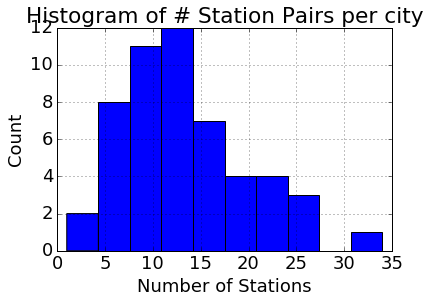

In [40]:
N_list.max().hist()
plt.xlabel('Number of Stations')
plt.ylabel('Count')
plt.title('Histogram of # station pairs per city')

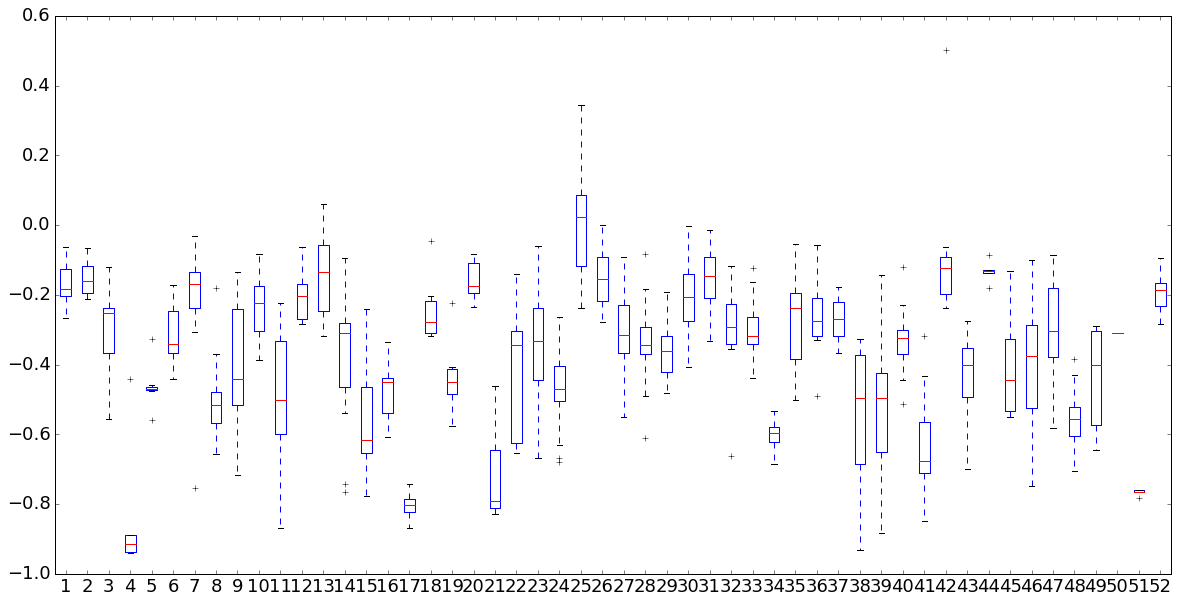

In [46]:
plt.figure(figsize=[20,10])
ax = plt.subplot(111) 
handles = ax.boxplot(M_list, vert = True)

In [47]:
results_filepath

'plots/version5/UHIvariance/'

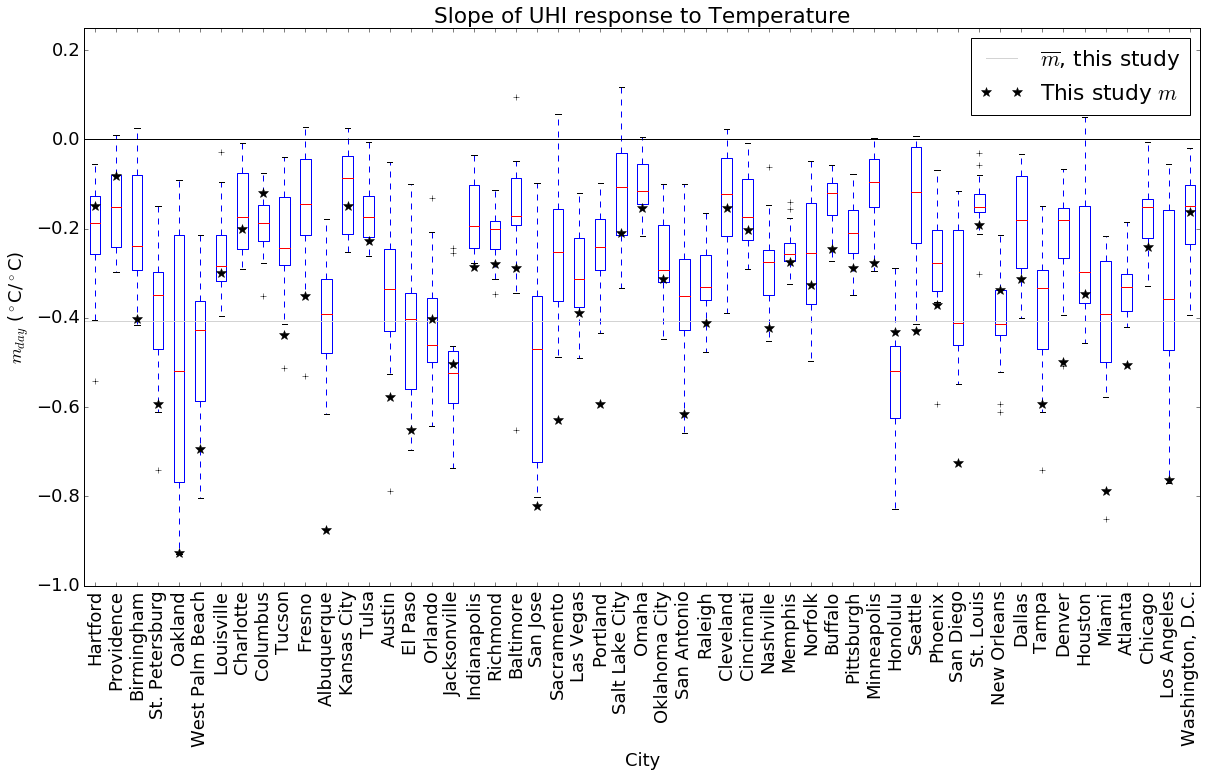

In [5]:
# Plot boxplots of slopes
drop_cities = ['Mesa','Long Beach', 'Grand Prairie', 'Virginia Beach', 'St. Paul' ]
JJAresults = pd.read_csv('plots/version3/US_results_cleaned_data.csv').set_index('City').drop(drop_cities, axis=0)

#cities = paired_df['City'].values
cities = JJAresults.index.values
M_list = []
for city in cities: #i in range(0,cities.shape[0]): # probalby need to redo 1-15
    #city = paired_df.iloc[i]['City']
    if city == 'Grand Prairie': 
        city = 'Arlington'
    try: 
        array = np.load(results_filepath+'slopes/'+ city.replace(" ", "")[0:5]+'m.npy')
        array = array[~np.isnan(array)]
        M_list.append(array)
        #M_list.append(np.load(results_filepath+'slopes/'+ city.replace(" ", "")[0:5]+'m.npy'))
    except IOError: 
#        M_list.append(np.loadtxt(results_filepath+'slopes/'+ city.replace(" ", "")[0:5]+'m.npy'))
        print('Skipping %s'%city)
#plt.figure(figsize=[20,4])
# plt.figure(figsize=[4,20])
# ax = plt.subplot(111) 
# ax.boxplot(M_list, vert = True)
# ax.hold('True')
# #Now load the calculated results 
# #set up fake x axis
# X = np.arange(0, cities.shape[0])
# Y = JJAresults['Slope'][cities]
# # ax.axhline(Y.mean(), color = 'lightgray', label = '$\overline{m}$')
# # ax.axhline(0, color = 'black', )
# ax.plot(Y, X, 'x', color = 'black')
# #ax.plot(X,Y, 'x', color = 'black')

# # ax.set_xlabel('City')
# # ax.set_xticklabels(cities, rotation = 45)
# # ax.set_ylabel('Slope ($\Delta T$)')
# # ax.set_title('Slope of UHI response to Temperature')
# # plt.ylim([-1.5, .5])
# #plt.savefig(results_filepath+'allcitiesm.pdf')

plt.figure(figsize=[20,10])
ax = plt.subplot(111) 
ax.boxplot(M_list, vert = True)
ax.hold('True')
#Now load the calculated results 
#JJAresults = pd.read_csv('US_results_cleaned_data.csv').set_index('City')
#set up fake x axis
X = np.arange(1, cities.shape[0]+1)
Y = JJAresults['Slope'].loc[cities]
ax.axhline(Y.mean(), color = 'lightgray', label = '$\overline{m}$, this study')
ax.axhline(0, color = 'black', )
ax.plot(X,Y, '*', color = 'black', markerSize = 10, label = 'This study $m$')
ax.set_xlabel('City')
ax.set_xticklabels(cities, rotation = 90)
ax.set_ylabel('$m_{day}$ ($^\circ$C/$^\circ$C)')
#ax.set_title('Slope of UHI response to Temperature')
plt.ylim([-1., .25])
plt.legend()
plt.savefig(results_filepath+'allcitiesm.pdf', bbox_inches='tight')

In [47]:
# ask whether or not m_computed falls within range of m_possible
in_range = []
in_IQrange = []
i = 0
for array in M_list: 
    # if m_computed within range of m_possible
    try: 
        q75, q25 = np.percentile(array, [75 ,25])
        if (JJAresults['Slope'].iloc[i] < array.max() )& (JJAresults['Mean UHI'].iloc[i] > array.min()):
            in_range.append(1)
        if (JJAresults['Slope'].iloc[i] < q75 )& (JJAresults['Mean UHI'].iloc[i] > q25):
            in_IQrange.append(1)
        #array.max() - array.min()#)
    except IndexError: 
         print('error')
    #np.nanmax(array)-np.nanmin(array)
    i = i+1
print('M_computed within range of m_possible for %i out of %i cities (%2.2f percent)'%(sum(in_range),i, sum(in_range)/float(i)*100))
print('M_computed within IQ range of m_possible for %i out of %i cities (%2.2f percent)'%(sum(in_IQrange),i, sum(in_IQrange)/float(i)*100))

M_computed within range of m_possible for 51 out of 53 cities (96.23 percent)
M_computed within IQ range of m_possible for 49 out of 53 cities (92.45 percent)


In [48]:
a = []
for array in M_list: 
    try: 
        a.append(array.max() - array.min())
        #array.max() - array.min()#)
    except ValueError: 
        print('error')
    #np.nanmax(array)-np.nanmin(array)
np.mean(a)

0.49431622883930892

In [49]:
# How many average stations?
a = []
for array in M_list: 
    try: 
        a.append(array.shape[0])
        #array.max() - array.min()#)
    except ValueError: 
        print('error')
    #np.nanmax(array)-np.nanmin(array)
np.mean(a)
#np.std(a)

13.660377358490566

In [50]:
# compute underestimates 

# average data 
means = []
for array in M_list: 
    try: 
        means.append(array.mean())
        #array.max() - array.min()#)
    except ValueError: 
        print('error')
    #np.nanmax(array)-np.nanmin(array)

underestimates = np.where(JJAresults['Slope'][cities] < means)[0]
print('My method underestimates slope for %i cities'%underestimates.shape)
overestimates = np.where((JJAresults['Slope'][cities]) > means)[0]
print('My method overestimates slopefor %i cities'%overestimates.shape)
print('Mean difference is %3.3f $^\circ$C'%((JJAresults['Slope'][cities] -np.array(means)).mean()))

My method underestimates slope for 44 cities
My method overestimates slopefor 9 cities
Mean difference is -0.134 $^\circ$C


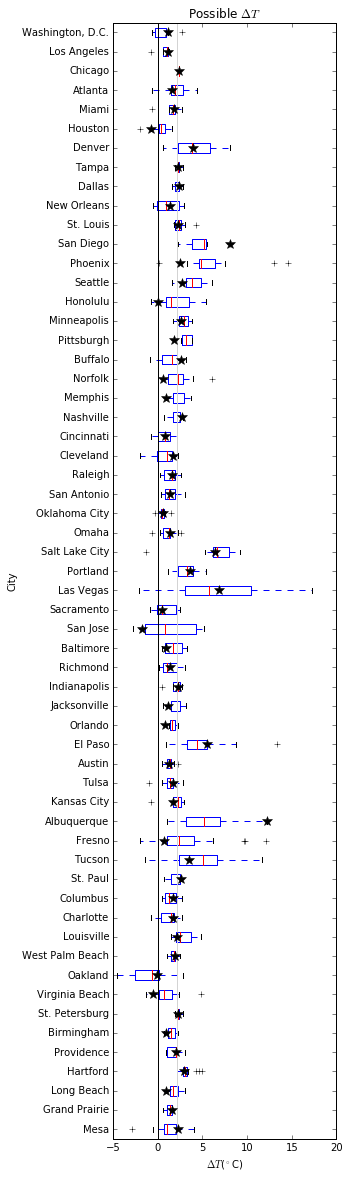

In [818]:
# Plot boxplots of UHI range

#cities = paired_df['City'].values
cities = []
M_list = []
for i in range(0,paired_df.shape[0]): # probalby need to redo 1-15
    city = paired_df.iloc[i]['City']
    if city == 'Grand Prairie': 
        city = 'Arlington'
#     try: 
#         M_list.append(np.load(results_filepath+'UHIs/'+ city.replace(" ", "")[0:5]+'UHI.npy'))
#     except IOError: 
#         M_list.append(np.loadtxt(results_filepath+'UHIs/'+ city.replace(" ", "")[0:5]+'UHI.npy'))
    try: 
        array = np.load(results_filepath+'UHIs/'+ city.replace(" ", "")[0:5]+'UHI.npy')
        array = array[~np.isnan(array)]
        M_list.append(array)
        if city =='Arlington': 
            cities.append('Grand Prairie')
        else: 
            cities.append(city)
        #M_list.append(np.load(results_filepath+'UHIs/'+ city.replace(" ", "")[0:5]+'UHI.npy'))
    except IOError: 
        #M_list.append(np.loadtxt(results_filepath+'UHIs/'+ city.replace(" ", "")[0:5]+'UHI.npy'))
        print('Skipping %s'%city)

# plt.figure(figsize=[20,4])
# ax = plt.subplot(111) 
# ax.boxplot(M_list)
# ax.hold('True')
# #Now load the calculated results 
# JJAresults = pd.read_csv('US_results_cleaned_data.csv').set_index('City')
# #set up fake x axis
# X = np.arange(0, cities.shape[0])
# Y = JJAresults['Mean UHI'][cities]
# ax.axhline(Y.mean(), color = 'lightgray', label = '$\overline{m}$')
# ax.axhline(0,color = 'black')
# ax.plot(X,Y, 'x', color = 'black')
# ax.set_xlabel('City')
# ax.set_xticklabels(cities, rotation = 45)
# ax.set_ylabel('$\Delta T$ ($^\circ C$)')
# ax.set_title('UHI per City')
# plt.savefig(results_filepath+'allcitiesUHI.pdf')

plt.figure(figsize=[4,20])
ax = plt.subplot(111) 
ax.boxplot(M_list, vert = False)
ax.hold('True')
#Now load the calculated results 
#JJAresults = pd.read_csv('US_results_cleaned_data.csv').set_index('City')
#set up fake x axis
#X = np.arange(0, cities.shape[0])
Y = np.arange(1, len(cities)+1)
X= JJAresults['Mean UHI'][cities]
ax.axvline(X.mean(), color = 'lightgray', label = '$\overline{m}$')
ax.axvline(0, color = 'black', )
ax.plot( X, Y,'*',#'x', 
        color = 'black', markerSize = 10)
ax.set_ylabel('City')
ax.set_yticklabels(cities)#, rotation = 45)
ax.set_xlabel('$\Delta T$($^\circ$C)')
ax.set_title('Possible $\Delta T$')
#plt.xlim([-1.5, .5])
plt.savefig(results_filepath+'allcitiesUHI.pdf', bbox_inches='tight')

In [764]:
len(M_list)

58

In [761]:
# ask whether or not m_computed falls within range of m_possible
in_range = []
in_IQrange = []
i = 0
for array in M_list: 
    # if m_computed within range of m_possible
    try: 
        q75, q25 = np.percentile(array, [75 ,25])
        if (JJAresults['Mean UHI'].iloc[i] < array.max() )& (JJAresults['Mean UHI'].iloc[i] > array.min()):
            in_range.append(1)
        if (JJAresults['Mean UHI'].iloc[i] < q75 )& (JJAresults['Mean UHI'].iloc[i] > q25):
            in_IQrange.append(1)
        #array.max() - array.min()#)
    except IndexError: 
         print('error')
    #np.nanmax(array)-np.nanmin(array)
    i = i+1
print('UHI_computed within range of UHI_possible for %i out of %i cities (%2.2f percent)'%(sum(in_range),i, sum(in_range)/float(i)*100))
print('UHI_computed within IQ range of UHI_possible for %i out of %i cities (%2.2f percent)'%(sum(in_IQrange),i, sum(in_IQrange)/float(i)*100))

UHI_computed within range of UHI_possible for 52 out of 58 cities (89.66 percent)
UHI_computed within IQ range of UHI_possible for 31 out of 58 cities (53.45 percent)


In [767]:
Y.mean()

2.1057389858350986

In [768]:
# compute underestimates 

# average data 
means = []
for array in M_list: 
    try: 
        means.append(array.mean())
        #array.max() - array.min()#)
    except ValueError: 
        print('error')
    #np.nanmax(array)-np.nanmin(array)

underestimates = np.where(JJAresults['Mean UHI'][cities] < means)[0]
print('My method underestimates UHI for %i cities'%underestimates.shape)
overestimates = np.where((JJAresults['Mean UHI'][cities]) > means)[0]
print('My method overestimates UHI for %i cities'%overestimates.shape)
print('Mean difference is %3.3f $^\circ$C'%((JJAresults['Mean UHI'][cities] -np.array(means)).mean()))

My method underestimates UHI for 28 cities
My method overestimates UHI for 30 cities
Mean difference is -0.081 $^\circ$C


In [770]:
# mean difference in UHI is 
(JJAresults['Mean UHI'][cities] - means).mean()

-0.08086480019654187

In [771]:
# range of UHI estimates
a = []
for array in M_list: 
    try: 
        a.append(array.max() - array.min())
        #array.max() - array.min()#)
    except ValueError: 
        print('error')
    #np.nanmax(array)-np.nanmin(array)
print('Mean range', np.mean(a), '\n Std. Deviation', np.std(a))

('Mean range', 4.4880136332522351, '\n Std. Deviation', 3.911565091725909)


In [107]:
JJAresults.columns

Index([u'Unnamed: 0', u'Slope', u'Intercepts', u'Residual', u'Correlation',
       u'P-value', u'Urban start date', u'Urban end date', u'Rural start date',
       u'Rural end date', u'Data points', u'Mean UHI', u'Day of Max UHI',
       u'Mean JJA Rural Temp', u'UHI linear trend',
       u'UHI linear trend p-value', u'hw Slope', u'hw Residual',
       u'hw Correlation', u'hw Data points', u'hw Mean UHI',
       u'hw Mean JJA Rural Temp'],
      dtype='object')

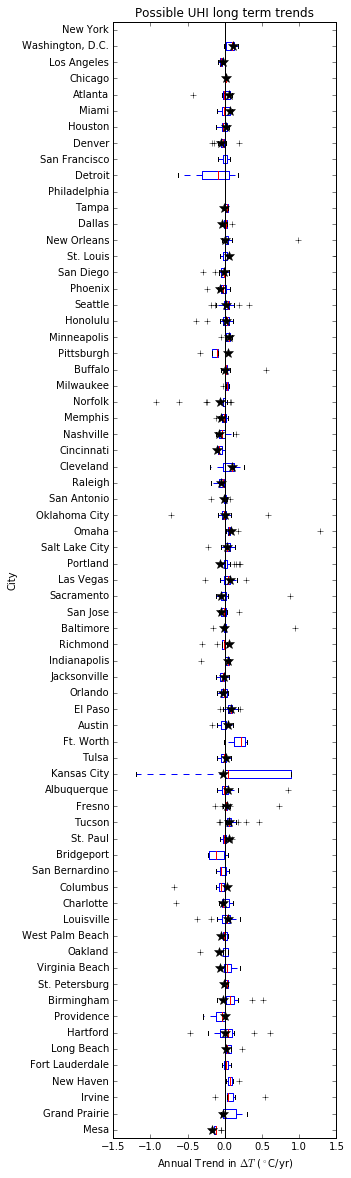

In [109]:
## long term  UHI trends 

#         np.save(results_filepath+'30yrtrend/'+ city.replace(" ", "")[0:5]+'30yrTrslopes.npy', mean_Trslopes)
#         np.save(results_filepath+'30yrtrend/'+ city.replace(" ", "")[0:5]+'30yrUHIslopes.npy', mean_UHIslopes)
# Plot boxplots of trends 
#cities = paired_df['City'].values
cities = []
M_list = []
for i in range(0,paired_df.shape[0]): # probalby need to redo 1-15
    city = paired_df.iloc[i]['City']
    if city == 'Grand Prairie': 
        city = 'Arlington'
    try: 
        array = np.load(results_filepath+'30yrtrend/'+ city.replace(" ", "")[0:5]+'30yrUHIslopes.npy')
        array = array[~np.isnan(array)]
        M_list.append(array)
        if city =='Arlington': 
            cities.append('Grand Prairie')
        else: 
            cities.append(city)
        #M_list.append(np.load(results_filepath+'UHIs/'+ city.replace(" ", "")[0:5]+'UHI.npy'))
    except IOError: 
        #M_list.append(np.loadtxt(results_filepath+'UHIs/'+ city.replace(" ", "")[0:5]+'UHI.npy'))
        print('Skipping %s'%city)


plt.figure(figsize=[4,20])
ax = plt.subplot(111) 
ax.boxplot(M_list, vert = False)
ax.hold('True')
#Now load the calculated results 
#JJAresults = pd.read_csv('US_results_cleaned_data.csv').set_index('City')
#set up fake x axis
#X = np.arange(0, cities.shape[0])
Y = np.arange(1, len(cities)+1)
X= JJAresults['UHI linear trend'][cities]
ax.axvline(X.mean(), color = 'lightgray', label = '$\overline{\Delta T/yr}$')
ax.axvline(0, color = 'black', )
ax.plot( X, Y,'*',#'x', 
        color = 'black', markerSize = 10)
ax.set_ylabel('City')
ax.set_yticklabels(cities)#, rotation = 45)
ax.set_xlabel('Annual Trend in $\Delta T$ ($^\circ$C/yr)')
ax.set_title('Possible UHI long term trends')
plt.xlim([-1.5, 1.5])
plt.savefig(results_filepath+'allcitiesUHItrend.pdf')